# COGS 108 - Final Project

# Names

- Salma Sheriff
- Mizuki Kadowaki 
- Zoe Lederman 
- Yashaswat Malhotra


<a id='research_question'></a>
# Research Question

Does the perceived citizen happiness correlate with COVID-19 outcomes?

# Dataset(s)

Dataset Name: World Happiness Report
Link to the dataset: https://www.kaggle.com/unsdsn/world-happiness (https://www.kaggle.com/unsdsn/world-happiness)
Number of observations:
Results compiled from a happiness survey in countries, used to provide a happiness score and rank the happiness of 155 countries in 2019.

Dataset Name: COVID-19 Coronavirus Complete Dataset
Link to the dataset: https://www.kaggle.com/ashudata/covid19dataset? select=COVID_Data_Basic.csv (https://www.kaggle.com/ashudata/covid19dataset? select=COVID_Data_Basic.csv)
Number of observations:

Reports on outcomes of COVID-19 (confirmed cases, deaths, etc.) in 194 unique countries between 12/31/2019 - 11/6/2020.

We plan to combine these datasets based on county. We will only be using countries that are present in both of these datasets.


# Setup

In [256]:
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

import hvplot.pandas
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from vega_datasets import data
import altair as alt

In [257]:
# import datasets
happy_2019 = pd.read_csv("data/2019.csv")
covid_basic = pd.read_csv("data/COVID_Data_Basic.csv")
pop_dens = pd.read_csv("data/population_by_country_2020.csv")

# world map. For choropleths
countries = pd.read_csv("data/countries.csv")
countries_topo = alt.topo_feature(data.world_110m.url, 'countries')

The columns following the happiness score estimate the extent to which each of six factors – economic production, social support, life expectancy, freedom, absence of corruption, and generosity – contribute to making life evaluations higher in each country than they are in Dystopia, a hypothetical country that has values equal to the world’s lowest national averages for each of the six factors.


# Data Cleaning

*For COVID Dataset*
1. Remove data from before January 2020 and after November 2020.
2. Remove cruise ships and countries that do not have any data between January and November 2020. 
3. Drop newConfirmed, newDeath, and newRecovered columns.
4. Convert the Data column values from String type to date-time type.
5. Remove countries that are not in Happiness datasets.

## Covid Dataset

In [258]:
#datetime.strptime('')
covid_basic['Date'] = pd.to_datetime(covid_basic['Date'])

# Code for removing all data sets before January 2020
covid_test = covid_basic[~(covid_basic['Date'] < '2020-01-01')]

#Code for removing all data sets after November 2020
#This was done because not all countries have updated data after November.
covid_test = covid_test[~(covid_test['Date'] > '2020-10-31')]

In [259]:
#getting different properties of the original dataset, to compare with changes we make
covid_basic.head()
covid_basic.Date[0]
covid_basic.shape

(54522, 9)

In [260]:
#checking the same properties on a test dataset to see if we've made the desired changes
covid_test.head()
covid_test.Date[1]
covid_test.shape

(53316, 9)

In [261]:
#both datasets have 194 countries
len(covid_basic['Country'].unique()) == len(covid_test['Country'].unique())

True

In [262]:
#checking countries that are in covid dataset but not in happy
# np.setdiff1d(covid_test['Country'] , happy_2019['Country or region'])

In [263]:
#checking countries that are in happiness dataset but not in covid
# np.setdiff1d(happy_2019['Country or region'], covid_test['Country'])

In [264]:
#renaming countries that are the same but entered differently
covid_test = covid_test.replace(["Czechia", "Cote d'Ivoire", "Burma", 
                    "West Bank and Gaza", "Korea, South", 
                    "Eswatini","Taiwan*","Trinidad and Tobago", "US"],
                   ['Czech Republic', 'Ivory Coast', 'Myanmar',
                    'Palestinian Territories', 'South Korea',
                    'Swaziland', 'Taiwan', 'Trinidad & Tobago',
                    'United States'])

In [265]:
#removing countries that are in covid dataset and not in happiness dataset
covid_test = covid_test[~covid_test['Country'].isin(['Andorra','Angola', 'Antigua and Barbuda', 'Bahamas',
       'Bahamas, The', 'Barbados', 'Belize', 'Brunei', 'Cabo Verde',
       'Cruise Ship', 'Cuba', 'Diamond Princess', 'Djibouti', 'Dominica',
       'Equatorial Guinea', 'Eritrea', 'Fiji', 'Gambia, The', 'Grenada',
       'Guinea-Bissau', 'Guyana', 'Holy See', 'Liechtenstein',
       'MS Zaandam', 'Maldives', 'Marshall Islands', 'Martinique',
       'Monaco', 'Oman', 'Papua New Guinea', 'Saint Kitts and Nevis',
       'Saint Lucia', 'Saint Vincent and the Grenadines', 'San Marino',
       'Sao Tome and Principe', 'Seychelles', 'Solomon Islands', 'Sudan',
       'Suriname', 'Timor-Leste', 'Western Sahara','Kosovo'])]

In [266]:
#removing countries that are in happiness dataset and not in covid dataset
happy_2019 = happy_2019[~happy_2019['Country or region'].isin(['Hong Kong', 'Northern Cyprus', 'Turkmenistan'])]

## Population Dataset

In [267]:

pop_dens.head()

pop_dens = pop_dens.drop(['Yearly Change', 'Net Change', 'Migrants (net)', 
                          'Fert. Rate', 'Med. Age', 'Urban Pop %', 'World Share'], axis =1)
pop_dens.head()

pop_dens.shape
#more countries in this dataset since we haven't standardized it yet

#checking countries that are in pop_dens dataset but not in happy
np.setdiff1d(pop_dens['Country (or dependency)'] , happy_2019['Country or region'])

#checking countries that are in happiness dataset but not in pop_dens
np.setdiff1d(happy_2019['Country or region'], pop_dens['Country (or dependency)'])

#renaming countries that are the same but entered differently; standardizing to happiness dataset
pop_dens = pop_dens.replace(["Czech Republic (Czechia)", "Côte d'Ivoire", 
                    "State of Palestine", 'Congo','DR Congo',
                    "Eswatini","Trinidad and Tobago"],
                   ['Czech Republic', 'Ivory Coast',
                    'Palestinian Territories','Congo (Brazzaville)', 'Congo (Kinshasa)',
                    'Swaziland', 'Trinidad & Tobago'])

#checking countries that are in happiness dataset but not in pop_dens
np.setdiff1d(happy_2019['Country or region'], pop_dens['Country (or dependency)'])

#checking countries that are in pop_dens dataset but not in happy
np.setdiff1d(pop_dens['Country (or dependency)'] , happy_2019['Country or region'])

#removing countries that are in pop_dens dataset and not in happiness dataset
pop_dens = pop_dens[~pop_dens['Country (or dependency)'].isin(['American Samoa', 'Andorra', 'Angola', 'Anguilla',
       'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Belize',
       'Bermuda', 'British Virgin Islands', 'Brunei', 'Cabo Verde',
       'Caribbean Netherlands', 'Cayman Islands', 'Channel Islands',
       'Cook Islands', 'Cuba', 'Curaçao', 'Djibouti', 'Dominica',
       'Equatorial Guinea', 'Eritrea', 'Faeroe Islands',
       'Falkland Islands', 'Fiji', 'French Guiana', 'French Polynesia',
       'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam',
       'Guinea-Bissau', 'Guyana', 'Holy See', 'Isle of Man', 'Kiribati',
       'Liechtenstein', 'Macao', 'Maldives', 'Marshall Islands',
       'Martinique', 'Mayotte', 'Micronesia', 'Monaco', 'Montserrat',
       'Nauru', 'New Caledonia', 'Niue', 'North Korea',
       'Northern Mariana Islands', 'Oman', 'Palau', 'Papua New Guinea',
       'Puerto Rico', 'Réunion', 'Saint Barthelemy', 'Saint Helena',
       'Saint Kitts & Nevis', 'Saint Lucia', 'Saint Martin',
       'Saint Pierre & Miquelon', 'Samoa', 'San Marino',
       'Sao Tome & Principe', 'Seychelles', 'Sint Maarten',
       'Solomon Islands', 'St. Vincent & Grenadines', 'Sudan', 'Suriname',
       'Timor-Leste', 'Tokelau', 'Tonga', 'Turks and Caicos', 'Tuvalu',
       'U.S. Virgin Islands', 'Vanuatu', 'Wallis & Futuna',
       'Western Sahara','Hong Kong', 'Turkmenistan'])]




## Happiness Dataset

In [268]:
#removing countries that are in happiness dataset and not in covid dataset
happy_2019 = happy_2019[~happy_2019['Country or region'].isin(['Kosovo', 'Northern Cyprus'])]

# happy_2019

# pop_dens

In [269]:
#checking countries that are in happiness dataset but not in covid_test; should be empty
np.setdiff1d(happy_2019['Country or region'], covid_test['Country'])

#checking countries that are in covid_test dataset but not in happy; should be empty
np.setdiff1d(covid_test['Country'] , happy_2019['Country or region'])

array([], dtype=object)

## Covid dataset
Modified to match 

In [270]:
#checking countries that are in pop_dens dataset but not in covid_test; should be empty
np.setdiff1d(pop_dens['Country (or dependency)'], covid_test['Country'])

#checking countries that are in covid_test dataset but not in pop_dens; should be empty
np.setdiff1d(covid_test['Country'] , pop_dens['Country (or dependency)'])

array([], dtype=object)

In [271]:
# covid_test.sort_values(by = 'Country', ascending = True)

In [272]:
#make month column to make it easy to sum by month
covid_test['Month'] = covid_test['Date'].dt.month

#code for adding all the data for each country by month
covid_test = covid_test.groupby(['Country','Month']).max()
covid_test.head()

Unnamed: 0       Date  Confirmed  Death  Recovered  \
Country     Month                                                       
Afghanistan 1              32 2020-01-31          0      0          0   
            2              61 2020-02-29          1      0          0   
            3           70100 2020-03-31        174      4          5   
            4          100100 2020-04-30       2171     64        260   
            5          131100 2020-05-31      15205    257       1328   

                   newConfirmed  newDeath  newRecovered  
Country     Month                                        
Afghanistan 1                 0         0             0  
            2                 1         0             0  
            3                50         2             3  
            4               232         7            45  
            5               866        17            80

In [273]:
#dropping column named "unnamed" that contained the index before the data set was altered
covid_test = covid_test.drop(columns = 'Unnamed: 0')

In [274]:
covid_test.head()
covid_test.shape

#renaming covid dataset for ease
covid_clean = covid_test

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

## Happiness Dataset

(array([ 1.,  3.,  3.,  3.,  3.,  4.,  5.,  8., 12., 12.,  6.,  9.,  9.,
         7.,  8.,  8., 13., 11.,  3.,  3.,  4.,  6.,  5.,  4.,  2.]),
 array([2.853  , 3.04964, 3.24628, 3.44292, 3.63956, 3.8362 , 4.03284,
        4.22948, 4.42612, 4.62276, 4.8194 , 5.01604, 5.21268, 5.40932,
        5.60596, 5.8026 , 5.99924, 6.19588, 6.39252, 6.58916, 6.7858 ,
        6.98244, 7.17908, 7.37572, 7.57236, 7.769  ]),
 <a list of 25 Patch objects>)

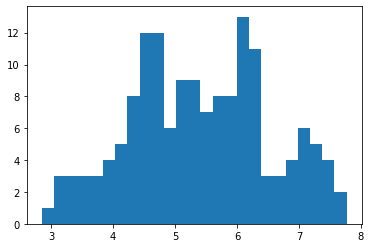

In [275]:
# plotting a histogram of the happiness data
# to get an overview of happiness distribution across all countries

plt.hist(happy_2019['Score'],bins = 25)

# based on this distribution, the happiness scores across countries 
# may follow a bimodal distribution


Text(0, 0.5, 'quantity')

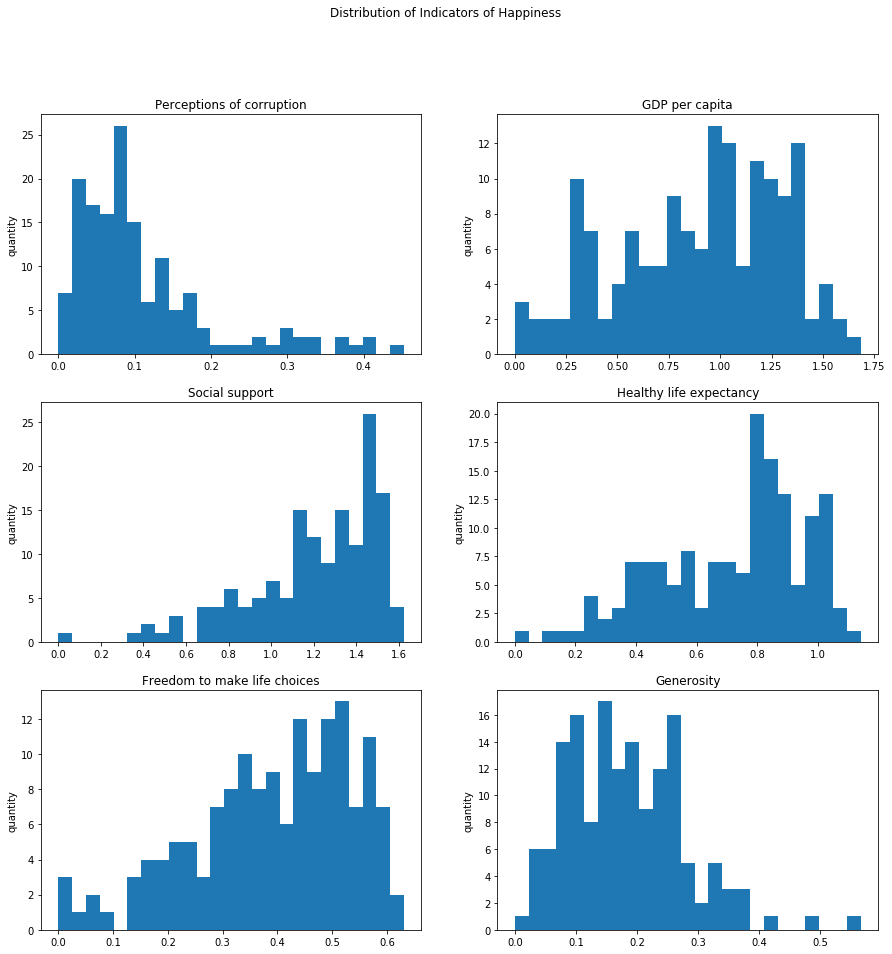

In [276]:
# making histograms for each of the six happiness subscores
# to get a distribution of each of the factors across all countries
fig, axs = plt.subplots(3, 2, figsize=(15,15))

fig.suptitle('Distribution of Indicators of Happiness')

axs[0,0].hist(happy_2019['Perceptions of corruption'], bins=25)
axs[0,1].hist(happy_2019['GDP per capita'],bins=25)
axs[1,0].hist(happy_2019['Social support'],bins=25)
axs[1,1].hist(happy_2019['Healthy life expectancy'],bins=25)
axs[2,0].hist(happy_2019['Freedom to make life choices'],bins=25)
axs[2,1].hist(happy_2019['Generosity'],bins=25)
axs[0, 0].set_title('Perceptions of corruption')
axs[0, 1].set_title('GDP per capita')
axs[1, 0].set_title('Social support')
axs[1, 1].set_title('Healthy life expectancy')
axs[2, 0].set_title('Freedom to make life choices')
axs[2, 1].set_title('Generosity')

axs[0,0].set_ylabel('quantity')
axs[0,1].set_ylabel('quantity')
axs[1,0].set_ylabel('quantity')
axs[1,1].set_ylabel('quantity')
axs[2,0].set_ylabel('quantity')
axs[2,1].set_ylabel('quantity')


# based on these distributions, GDP per capita seems about normally distributed
# the other factors are skewed one way or the other, which means that the majority of countries have similar values for these factors
# and that we need to pay attention to outliers for these values

## Covid Dataset

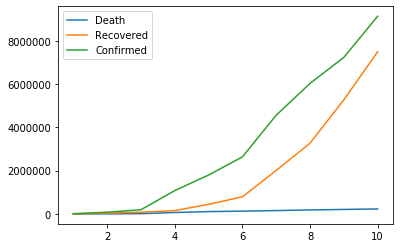

In [277]:
# making a temporary covid dataset to observe how covid cases, deaths, and recoveries increased over time
# grouping by month across all countries

temp = covid_test.copy()
temp["month"] = temp.index.get_level_values(1)
temp=temp.groupby("month").max()
temp['Month'] = temp.index

plt.plot('Month', 'Death', data=temp)
plt.plot('Month', 'Recovered', data = temp)
plt.plot('Month', 'Confirmed', data = temp)
plt.legend()

# we don't see any unexpected dips or spikes; cases rise logarithmically with time

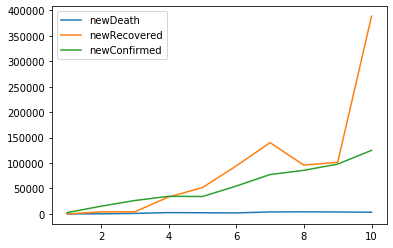

In [278]:
# making a temporary covid dataset to observe how covid cases, deaths, and recoveries increased over time
# grouping by month across all countries

plt.plot('Month', 'newDeath', data=temp)
plt.plot('Month', 'newRecovered', data = temp)
plt.plot('Month', 'newConfirmed', data = temp)
plt.legend()



In [279]:
covid_oct = covid_test.iloc[covid_test.index.get_level_values('Month') == 10]


## Population Dataset

In [280]:
temp_pop = pop_dens[["Country (or dependency)", "Population (2020)", "Density (P/Km²)"]].rename(columns={"Country (or dependency)": "name"})
temp_pop = temp_pop.replace({'name' : { 'United States':'USA'
                                       , 'Bolivia':'Bolivia (Plurinational State of)'
                                       , 'Brunei':'Brunei Darussalam' 
                                      , 'DR Congo':'Congo, Democratic Republic of the'
                                      , 'Czech Republic (Czechia)':'Czechia' 
                                      , 'North Korea':"Korea (Democratic People's Republic of)"
                                      , 'South Korea':'Korea, Republic of'
                                      , 'Iran':'Iran (Islamic Republic of)'
                                      , 'Laos':'Lao People\'s Democratic Republic'
                                      , 'Micronesia':'Micronesia (Federated States of)'
                                      , 'Moldova':'Moldova, Republic of'
                                      , 'Russia':'Russian Federation'
                                      , 'Saint Kitts & Nevis':'Saint Kitts and Nevis'
                                      , 'St. Vincent & Grenadines':'Saint Vincent and the Grenadines'
                                      , 'Sao Tome & Principe':'Sao Tome and Principe'
                                      , 'Syria':'Syrian Arab Republic'
                                      , 'Tanzania':'Tanzania, United Republic of'
                                      , 'United Kingdom':'United Kingdom of Great Britain and Northern Ireland'
                                      , 'Venezuela':'Venezuela (Bolivarian Republic of)'
                                      , 'Vietnam':'Viet Nam'}})

temp_pop = pd.merge(temp_pop, countries, on="name")

In [281]:
temp_pop.head()

,name,Population (2020),Density (P/Km²),id,alpha2,alpha3
0,China,1438207241,153,156,cn,chn
1,India,1377233523,464,356,in,ind
2,USA,330610570,36,840,us,usa
3,Indonesia,272931713,151,360,id,idn
4,Pakistan,219992900,287,586,pk,pak


In [282]:
base_map = alt.Chart(countries_topo).mark_geoshape(fill='lightgray',
    stroke='darkgray').project(type = 'equirectangular').properties(
    width = 500, height = 300, title = 'Population of each Country')


# Population count
choro_pop = alt.Chart(countries_topo).mark_geoshape().encode(
    color = alt.Color('Population (2020):Q', scale=alt.Scale(scheme="blues")),).transform_lookup(
    lookup ='id',from_=alt.LookupData(
        temp_pop,'id', ['Population (2020)'])).project(
    type = 'equirectangular').properties(width = 500, height = 300)

base_map + choro_pop

alt.LayerChart(...)

In [283]:
base_map = alt.Chart(countries_topo).mark_geoshape(fill='lightgray',
    stroke='darkgray').project(type = 'equirectangular').properties(
    width = 500, height = 300, title = 'Population Density of each Country')


# Population count
choro_dens = alt.Chart(countries_topo).mark_geoshape().encode(
    color = alt.Color('Density (P/Km²):Q', scale=alt.Scale(scheme="blues")),).transform_lookup(
    lookup ='id',from_=alt.LookupData(
        temp_pop,'id', ['Density (P/Km²)'])).project(
    type = 'equirectangular').properties(width = 500, height = 300)

base_map + choro_dens

alt.LayerChart(...)

### Merged Country and Covid

In [302]:
pop_dens = pop_dens.rename(columns={"Country (or dependency)": "Country"})
combined = pd.merge(covid_oct, pop_dens, on="Country").drop(['newConfirmed', 'newDeath', 'newRecovered'], axis=1)

## normalized based on population densigy
combined["Confirmed_norm"] = np.round(combined["Confirmed"] / combined["Population (2020)"], decimals=4)
combined["Death_norm"] = np.round(combined["Death"] / combined["Population (2020)"], decimals=4)
combined["Recovered_norm"] = np.round(combined["Recovered"] / combined["Population (2020)"], decimals=4)


Text(0, 0.5, 'quantity')

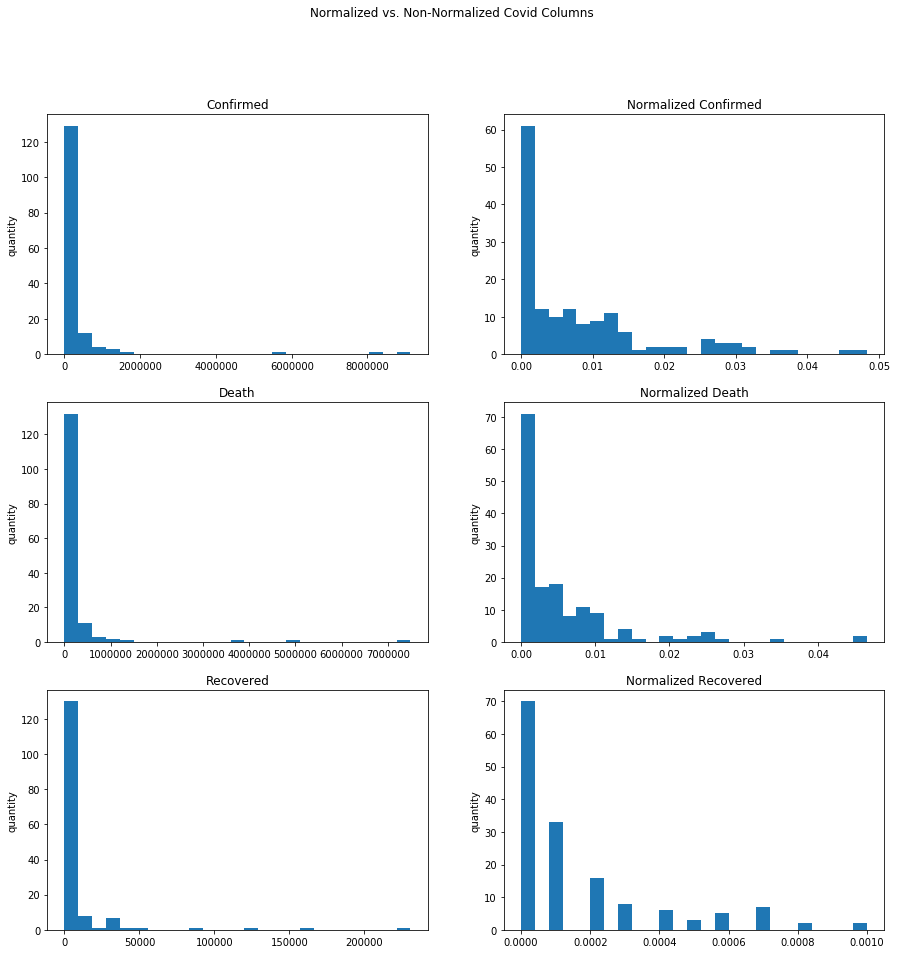

In [303]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))

fig.suptitle('Normalized vs. Non-Normalized Covid Columns')

axs[0,0].hist(combined["Confirmed"], bins=25)
axs[0,1].hist(combined["Confirmed_norm"],bins=25)
axs[1,0].hist(combined["Recovered"],bins=25)
axs[1,1].hist(combined["Recovered_norm"],bins=25)
axs[2,0].hist(combined["Death"],bins=25)
axs[2,1].hist(combined["Death_norm"],bins=25)
axs[0, 0].set_title('Confirmed')
axs[0, 1].set_title('Normalized Confirmed')
axs[1, 0].set_title('Death')
axs[1, 1].set_title('Normalized Death')
axs[2, 0].set_title('Recovered')
axs[2, 1].set_title('Normalized Recovered')

axs[0,0].set_ylabel('quantity')
axs[0,1].set_ylabel('quantity')
axs[1,0].set_ylabel('quantity')
axs[1,1].set_ylabel('quantity')
axs[2,0].set_ylabel('quantity')
axs[2,1].set_ylabel('quantity')

In [304]:
happy_2019 = happy_2019.rename(columns={"Country or region": "Country"})
covid_happy_area = pd.merge(combined, happy_2019, on="Country")
# covid_happy_area

Text(0, 0.5, 'Covid Recoveries')

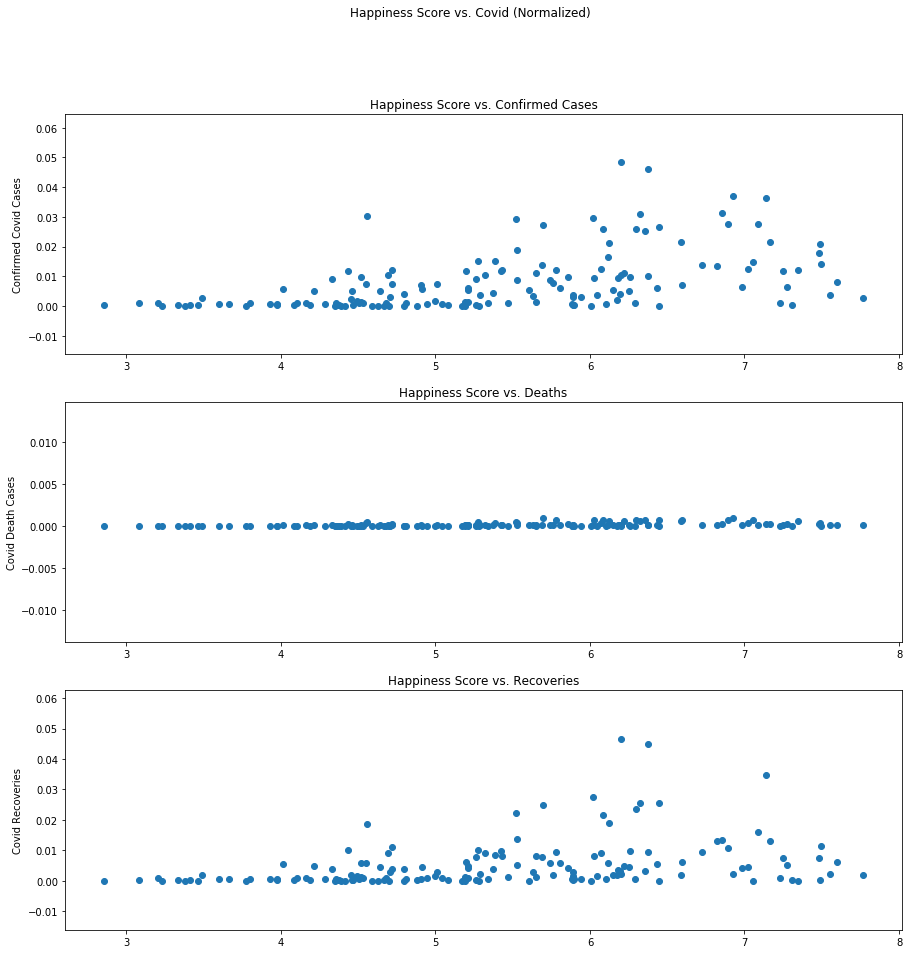

In [305]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

fig.suptitle('Happiness Score vs. Covid (Normalized)')

ax1.scatter(covid_happy_area["Score"], covid_happy_area["Confirmed_norm"])
ax1.set_title('Happiness Score vs. Confirmed Cases')
ax1.set_ylabel('Happiness Score')
ax1.set_ylabel('Confirmed Covid Cases')

ax2.scatter(covid_happy_area["Score"], covid_happy_area["Death_norm"])
ax2.set_title('Happiness Score vs. Deaths')
ax2.set_ylabel('Happiness Score')
ax2.set_ylabel('Covid Death Cases')

ax3.scatter(covid_happy_area["Score"], covid_happy_area["Recovered_norm"])
ax3.set_title('Happiness Score vs. Recoveries')
ax3.set_ylabel('Happiness Score')
ax3.set_ylabel('Covid Recoveries')


Text(0, 0.5, 'Covid Recoveries')

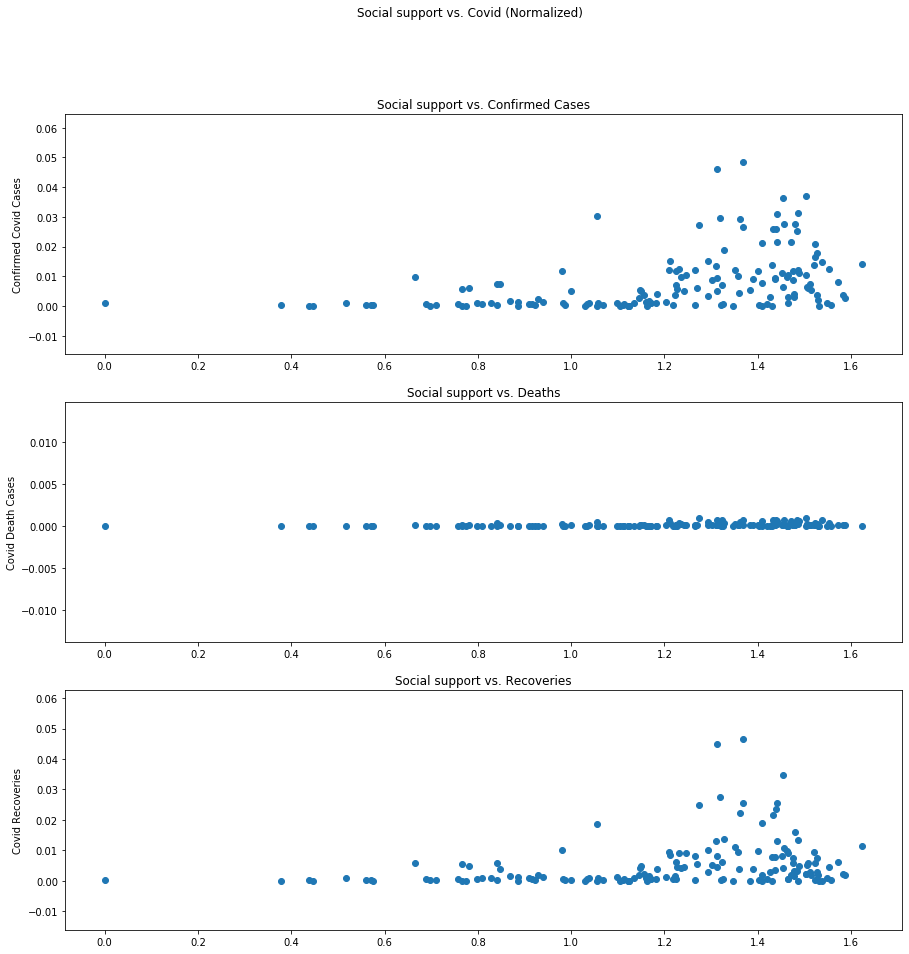

In [306]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

fig.suptitle('Social support vs. Covid (Normalized)')

ax1.scatter(covid_happy_area["Social support"], covid_happy_area["Confirmed_norm"])
ax1.set_title('Social support vs. Confirmed Cases')
ax1.set_ylabel('Social support')
ax1.set_ylabel('Confirmed Covid Cases')

ax2.scatter(covid_happy_area["Social support"], covid_happy_area["Death_norm"])
ax2.set_title('Social support vs. Deaths')
ax2.set_ylabel('Healthy life expectancy')
ax2.set_ylabel('Covid Death Cases')

ax3.scatter(covid_happy_area["Social support"], covid_happy_area["Recovered_norm"])
ax3.set_title('Social support vs. Recoveries')
ax3.set_ylabel('Social support')
ax3.set_ylabel('Covid Recoveries')


Text(0, 0.5, 'Covid Recoveries')

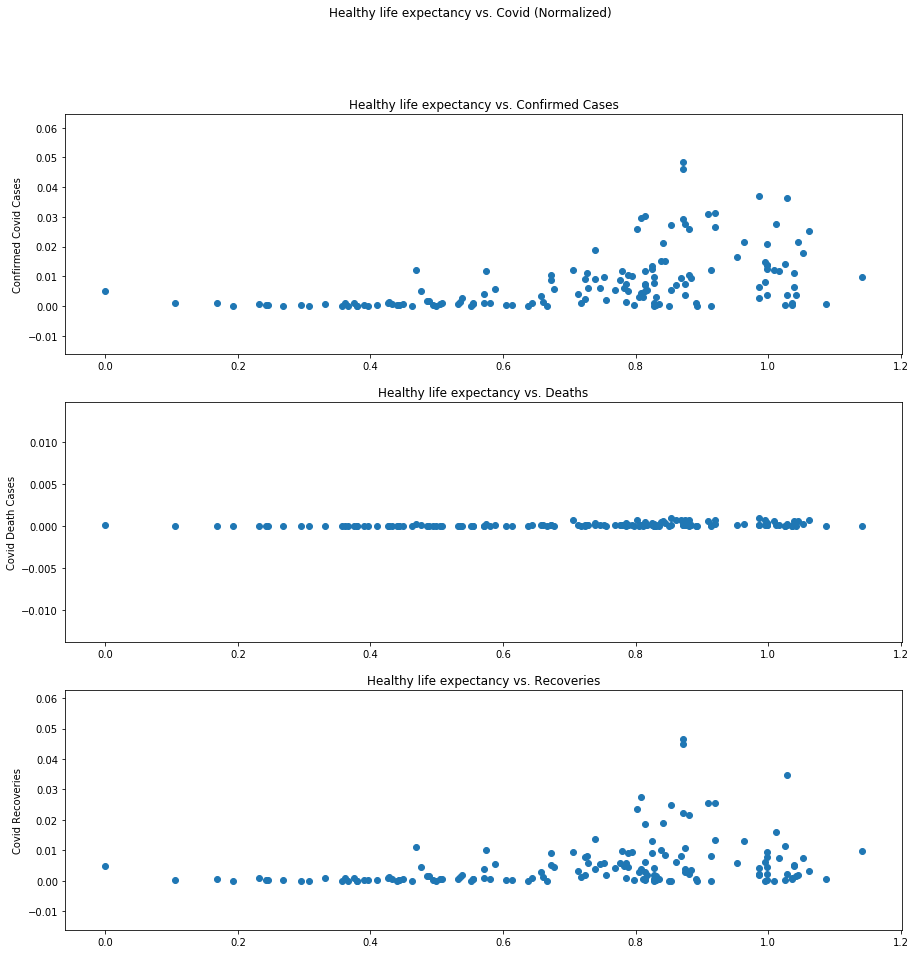

In [307]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

fig.suptitle('Healthy life expectancy vs. Covid (Normalized)')

ax1.scatter(covid_happy_area["Healthy life expectancy"], covid_happy_area["Confirmed_norm"])
ax1.set_title('Healthy life expectancy vs. Confirmed Cases')
ax1.set_ylabel('Healthy life expectancy')
ax1.set_ylabel('Confirmed Covid Cases')

ax2.scatter(covid_happy_area["Healthy life expectancy"], covid_happy_area["Death_norm"])
ax2.set_title('Healthy life expectancy vs. Deaths')
ax2.set_ylabel('Healthy life expectancy')
ax2.set_ylabel('Covid Death Cases')

ax3.scatter(covid_happy_area["Healthy life expectancy"], covid_happy_area["Recovered_norm"])
ax3.set_title('Healthy life expectancy vs. Recoveries')
ax3.set_ylabel('Healthy life expectancy')
ax3.set_ylabel('Covid Recoveries')


Text(0, 0.5, 'Covid Recoveries')

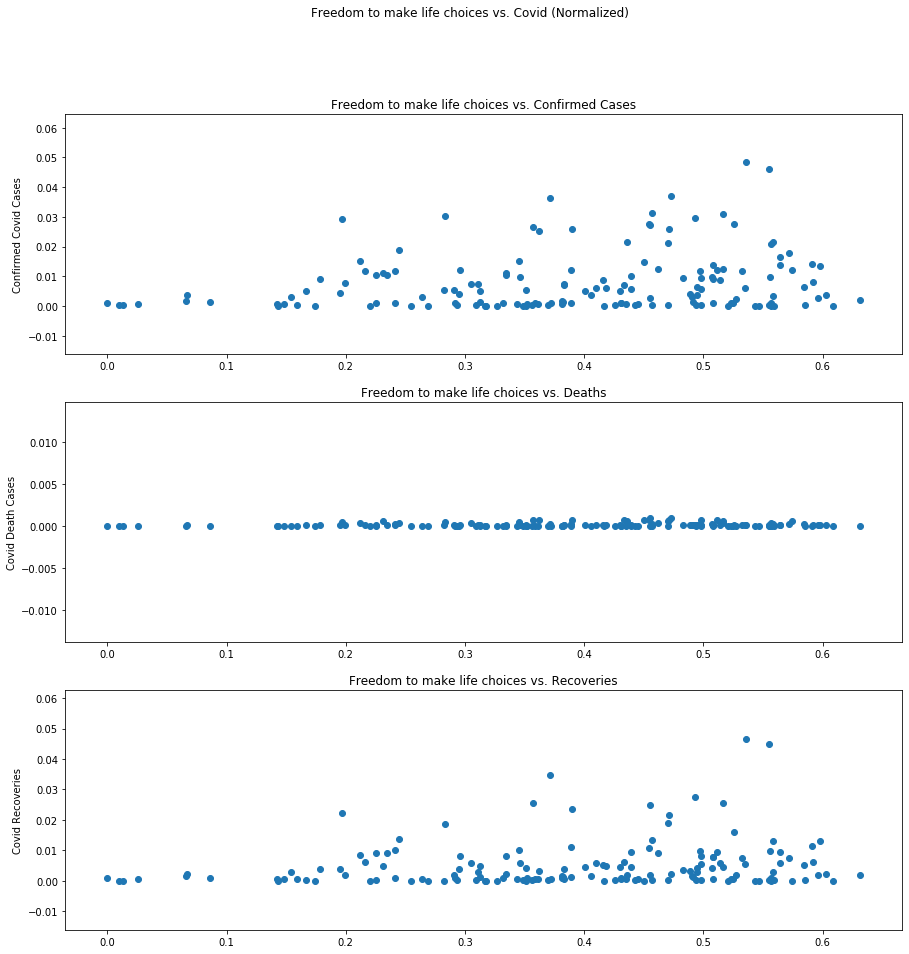

In [308]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

fig.suptitle('Freedom to make life choices vs. Covid (Normalized)')

ax1.scatter(covid_happy_area["Freedom to make life choices"], covid_happy_area["Confirmed_norm"])
ax1.set_title('Freedom to make life choices vs. Confirmed Cases')
ax1.set_ylabel('Freedom to make life choices')
ax1.set_ylabel('Confirmed Covid Cases')

ax2.scatter(covid_happy_area["Freedom to make life choices"], covid_happy_area["Death_norm"])
ax2.set_title('Freedom to make life choices vs. Deaths')
ax2.set_ylabel('Freedom to make life choices')
ax2.set_ylabel('Covid Death Cases')

ax3.scatter(covid_happy_area["Freedom to make life choices"], covid_happy_area["Recovered_norm"])
ax3.set_title('Freedom to make life choices vs. Recoveries')
ax3.set_ylabel('Freedom to make life choices')
ax3.set_ylabel('Covid Recoveries')

Text(0, 0.5, 'Covid Recoveries')

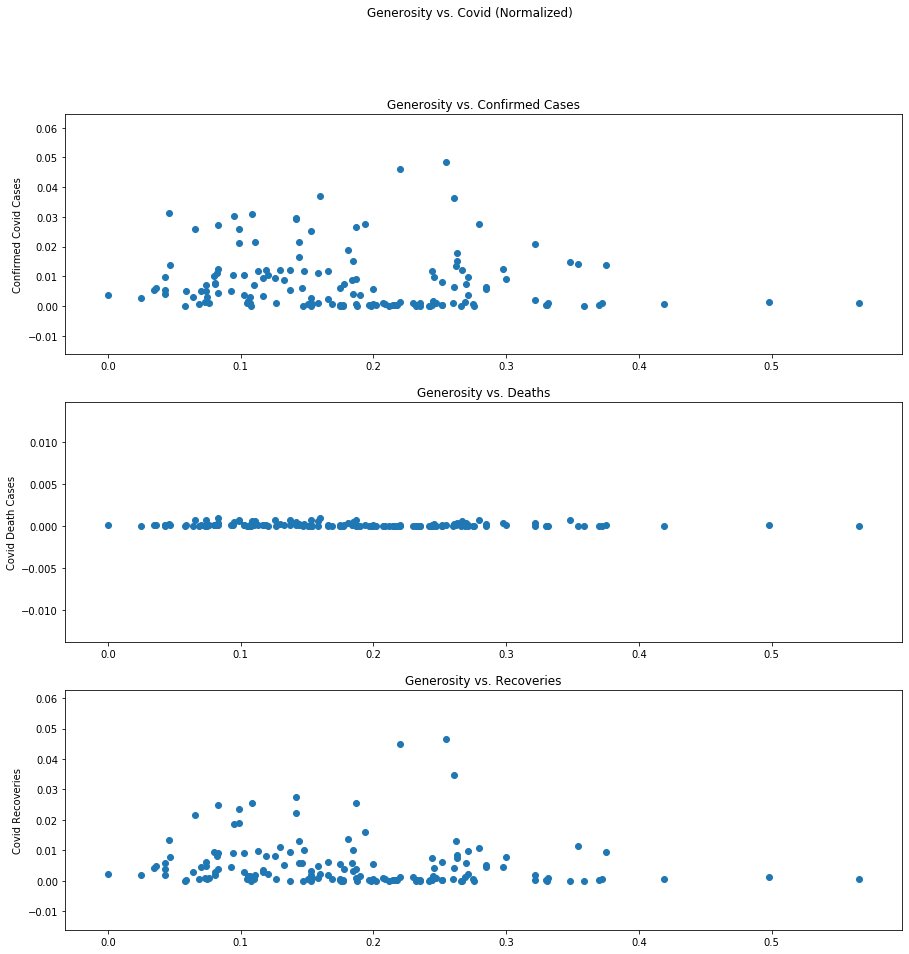

In [309]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

fig.suptitle('Generosity vs. Covid (Normalized)')

ax1.scatter(covid_happy_area["Generosity"], covid_happy_area["Confirmed_norm"])
ax1.set_title('Generosity vs. Confirmed Cases')
ax1.set_ylabel('Generosity')
ax1.set_ylabel('Confirmed Covid Cases')

ax2.scatter(covid_happy_area["Generosity"], covid_happy_area["Death_norm"])
ax2.set_title('Generosity vs. Deaths')
ax2.set_ylabel('Generosity')
ax2.set_ylabel('Covid Death Cases')

ax3.scatter(covid_happy_area["Generosity"], covid_happy_area["Recovered_norm"])
ax3.set_title('Generosity vs. Recoveries')
ax3.set_ylabel('Generosity')
ax3.set_ylabel('Covid Recoveries')

Text(0, 0.5, 'Covid Recoveries')

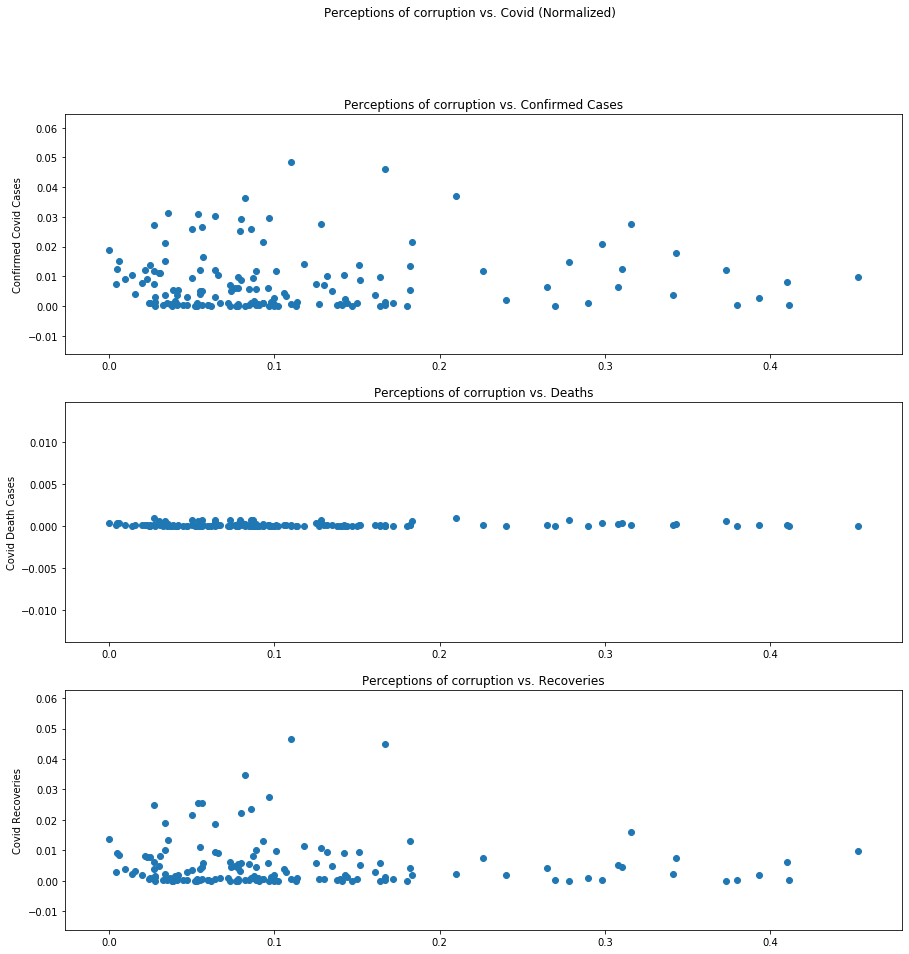

In [310]:
# Perceptions of corruption

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

fig.suptitle('Perceptions of corruption vs. Covid (Normalized)')

ax1.scatter(covid_happy_area["Perceptions of corruption"], covid_happy_area["Confirmed_norm"])
ax1.set_title('Perceptions of corruption vs. Confirmed Cases')
ax1.set_ylabel('Perceptions of corruption')
ax1.set_ylabel('Confirmed Covid Cases')

ax2.scatter(covid_happy_area["Perceptions of corruption"], covid_happy_area["Death_norm"])
ax2.set_title('Perceptions of corruption vs. Deaths')
ax2.set_ylabel('Perceptions of corruption')
ax2.set_ylabel('Covid Death Cases')

ax3.scatter(covid_happy_area["Perceptions of corruption"], covid_happy_area["Recovered_norm"])
ax3.set_title('Perceptions of corruption vs. Recoveries')
ax3.set_ylabel('Perceptions of corruption')
ax3.set_ylabel('Covid Recoveries')

# Linear Regression

### Happiness Score vs. Confirmed

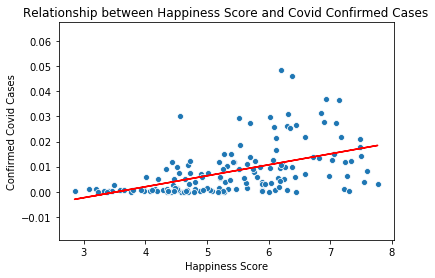

In [311]:
## Happiness Score vs. Confirmed 

ax = sns.scatterplot(x = 'Score', y = 'Confirmed_norm', data = covid_happy_area)
ax.set_title('Relationship between Happiness Score and Covid Confirmed Cases')
plt.xlabel('Happiness Score')
plt.ylabel('Confirmed Covid Cases')

a1, b1 = np.polyfit(covid_happy_area["Score"].values, covid_happy_area["Confirmed_norm"].values, 1)
yfit = [b1 + a1 * xi for xi in covid_happy_area["Score"]]
plt.plot(covid_happy_area["Score"], yfit, 'Red')

In [312]:
outcome, predictors = patsy.dmatrices('Score ~ Confirmed_norm', covid_happy_area)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     48.41
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           1.00e-10
Time:                        14:17:03   Log-Likelihood:                -211.96
No. Observations:                 152   AIC:                             427.9
Df Residuals:                     150   BIC:                             434.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.9478      0.103     48.

### Happiness Score vs. Death

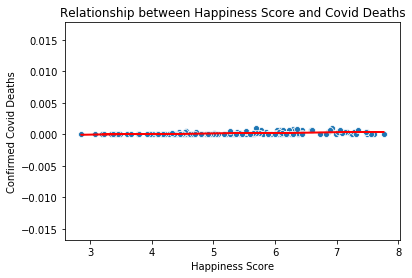

In [313]:
ax = sns.scatterplot(x = 'Score', y = 'Death_norm', data = covid_happy_area)
ax.set_title('Relationship between Happiness Score and Covid Deaths')
plt.xlabel('Happiness Score')
plt.ylabel('Confirmed Covid Deaths')

a1, b1 = np.polyfit(covid_happy_area["Score"].values, covid_happy_area["Death_norm"].values, 1)
yfit = [b1 + a1 * xi for xi in covid_happy_area["Score"]]
plt.plot(covid_happy_area["Score"], yfit, 'Red')

In [314]:
outcome, predictors = patsy.dmatrices('Score ~ Death_norm', covid_happy_area)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     34.94
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           2.20e-08
Time:                        14:17:03   Log-Likelihood:                -217.30
No. Observations:                 152   AIC:                             438.6
Df Residuals:                     150   BIC:                             444.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0620      0.101     50.351      0.0

### Happiness Score vs. Recovered

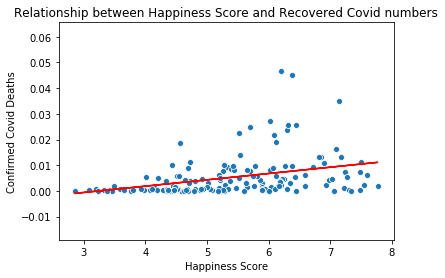

In [315]:
ax = sns.scatterplot(x = 'Score', y = 'Recovered_norm', data = covid_happy_area)
ax.set_title('Relationship between Happiness Score and Recovered Covid numbers')
plt.xlabel('Happiness Score')
plt.ylabel('Confirmed Covid Deaths')

a1, b1 = np.polyfit(covid_happy_area["Score"].values, covid_happy_area["Recovered_norm"].values, 1)
yfit = [b1 + a1 * xi for xi in covid_happy_area["Score"]]
plt.plot(covid_happy_area["Score"], yfit, 'Red')

In [316]:
outcome, predictors = patsy.dmatrices('Score ~ Recovered_norm', covid_happy_area)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     20.50
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           1.21e-05
Time:                        14:17:03   Log-Likelihood:                -223.48
No. Observations:                 152   AIC:                             451.0
Df Residuals:                     150   BIC:                             457.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.1421      0.103     49.

From this we can see that there is no significant correlation. 
However, we were curious to see what would happen if we excluded the few countries that had far more cases than other countries.

In [317]:
# Countries with over 50000 confirmed (normalized) 
covid_happy_area.loc[covid_happy_area["Confirmed_norm"] > 50000]

,Country,Date,Confirmed,Death,Recovered,Population (2020),Density (P/Km²),Land Area (Km²),Confirmed_norm,Death_norm,Recovered_norm,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption


# Project Proposal (updated)

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 1/20  |  1 PM | Read & Think about COGS 108 expectations; brainstorm topics/questions  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; begin background research | 
| 1/26  |  10 AM |  Do background research on topic | Discuss ideal dataset(s) and ethics; draft project proposal | 
| 2/1  | 10 AM  | Edit, finalize, and submit proposal; Search for datasets  | Discuss Wrangling and possible analytical approaches; Assign group members to lead each specific part   |
| 2/4  | 6 PM  | Import & Wrangle Data; EDA | Review/Edit wrangling/EDA; Discuss Analysis Plan   |
| 2/11  | 6 PM  | Finalize wrangling/EDA; Begin Analysis | Discuss/edit Analysis; Complete project check-in |
| 2/18  | 6 PM  | Complete analysis; Draft results/conclusion/discussion (Wasp)| Discuss/edit full project |
| 2/25  | Before 11:59 PM  | NA | Turn in Final Project & Group Project Surveys |